In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import *
from aeons.regress import *
from aeons.likelihoods import full
from aeons.plotting import *
# Set default matplotlib figure size to (4,2)
plt.rcParams['figure.figsize'] = (4,2)

In [2]:
def logf4(X, theta):
    logLmax, Delta, d, gamma = theta
    return logLmax - Delta * np.log(1 + X**(2/d)/gamma**2)

In [63]:
def logLmax_Delta_estimator(logL, X, d, gamma):
    N = len(logL)
    logXsum = np.sum( np.log(1 + X**(2/d)/gamma**2) )
    logLlogXsum = np.sum( logL * np.log(1 + X**(2/d)/gamma**2) )
    logXlogXsum = np.sum( (np.log(1 + X**(2/d)/gamma**2))**2 )
    logLsum = np.sum(logL)
    denom = (logXsum**2)/N - logXlogXsum
    logLmax_estimator = (logLlogXsum * logXsum/N - logXlogXsum * logLsum/N)/denom
    Delta_estimator = (logLlogXsum - logXsum * logLsum/N)/denom
    return logLmax_estimator, Delta_estimator

In [133]:
chain, samples = get_samples("toy", "gauss_30_01")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


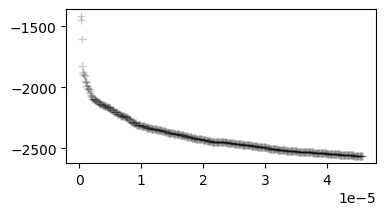

In [134]:
ndead = 5000
logL, X_mean, nk, logZdead = model.data(ndead)
window = np.arange(ndead, len(logL))
logLd, Xd = logL[window], X_mean[window]
plt.plot(Xd, logLd, 'k+', alpha=0.2)

In [64]:
def minimise_logf4(logL, X):
    def func(theta):
        d, gamma = theta
        logLmax, Delta = logLmax_Delta_estimator(logL, X, d, gamma)
        return np.sum( (logL - logf4(X, [logLmax, Delta, d, gamma]))**2 )
    from scipy.optimize import shgo
    res = shgo(func, bounds=[(0, 100), (0, 1)], n=256, iters=5)
    return res

1.78e+05


/tmp/ipykernel_98579/702299719.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  logXsum = np.sum( np.log(1 + X**(2/d)/gamma**2) )
/tmp/ipykernel_98579/702299719.py:3: RuntimeWarning: invalid value encountered in divide
  logXsum = np.sum( np.log(1 + X**(2/d)/gamma**2) )
/tmp/ipykernel_98579/702299719.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  logLlogXsum = np.sum( logL * np.log(1 + X**(2/d)/gamma**2) )
/tmp/ipykernel_98579/702299719.py:4: RuntimeWarning: invalid value encountered in divide
  logLlogXsum = np.sum( logL * np.log(1 + X**(2/d)/gamma**2) )
/tmp/ipykernel_98579/702299719.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  logXlogXsum = np.sum( (np.log(1 + X**(2/d)/gamma**2))**2 )
/tmp/ipykernel_98579/702299719.py:5: RuntimeWarning: invalid value encountered in divide
  logXlogXsum = np.sum( (np.log(1 + X**(2/d)/gamma**2))**2 )
/tmp/ipykernel_98579/702299719.py:3: RuntimeWarning: divide by zero encountered in divide


[40389.5453736249, 8049.294418515369, 93.75, 0.0625]

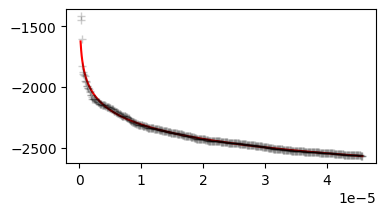

In [66]:
res = minimise_logf4(logLd, Xd)
d, gamma = res.x
logLmax, Delta = logLmax_Delta_estimator(logLd, Xd, d, gamma)
theta = [logLmax, Delta, d, gamma]
print(f"{res.fun:.2e}")
plt.plot(Xd, logf4(Xd, theta), 'r-')
plt.plot(Xd, logLd, 'k+', alpha=0.2)
theta

([31132.580885208466, 2562.9192817445364, 30, 0.001], '1.78e+05')

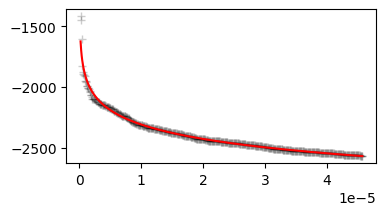

In [84]:
def loss(theta):
    logLmax, Delta, d, gamma = theta
    return np.sum( (logLd - logf4(Xd, [logLmax, Delta, d, gamma]))**2 )
d, gamma = 30, 0.001
logLmax, Delta = logLmax_Delta_estimator(logLd, Xd, d, gamma)
theta = [logLmax, Delta, d, gamma]
plt.plot(Xd, logLd, 'k+', alpha=0.2)
plt.plot(Xd, logf4(Xd, theta), 'r-')
theta, f"{loss(theta):.2e}"

In [131]:
from anesthetic import read_chains
theta_samples = read_chains(root="chains/gauss_5000")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/samples.py:1232: RuntimeWarning: 39 out of 802 samples have logL <= logL_birth,
39 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


In [132]:
theta_samples['loggamma'] = np.log(theta_samples['gamma'])

In [154]:
def numerical_logXf(theta, logZdead, logX0):
    # Do likelihood prediction with theta
    logX_pred = np.linspace(logX0, -500, 2000)
    X_pred = np.exp(logX_pred)
    logL_pred = logf4(X_pred, theta)
    dlogX = abs(np.diff(logX_pred)[0])
    logsummands_pred = logL_pred + logX_pred + np.log(dlogX)
    logZ_deads_pred = np.logaddexp(logZdead, np.logaddexp.accumulate(logsummands_pred))
    logZ_tot_pred = logZ_deads_pred[-1]
    log_differences = logZ_deads_pred - logZ_tot_pred
    logZ_fracs_pred = np.log(1 - np.exp(log_differences), where=log_differences != 0)
    return logX_pred[np.argmin(np.abs(logZ_fracs_pred - np.log(1e-3)))]

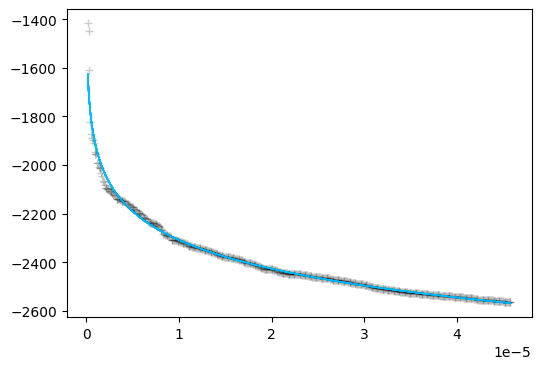

In [183]:
from fgivenx import plot_lines

def f(X, theta):
    c, gamma = theta
    return logf4(X, [*logLmax_Delta_estimator(logLd, Xd, c, gamma), c, gamma])

def calc_logXf(logZdead, theta):
    c, gamma = theta
    logLmax, Delta = logLmax_Delta_estimator(logLd, Xd, c, gamma)
    return numerical_logXf([logLmax, Delta, c, gamma], logZdead, Xd[0])

fig, ax = plt.subplots(figsize=(6, 4))
params = np.array([(c, gamma) for c, gamma in zip(theta_samples.c.values, theta_samples.gamma.values)])
plt.plot(Xd, logLd, 'k+', alpha=0.2)
plot_lines(f, Xd, params, ax, color='deepskyblue', lw=1)

In [138]:
# Calculate cauchy_logXf for each c, gamma in theta_samples
logXfs = np.zeros(len(theta_samples))
endpoints = np.zeros(len(theta_samples))
cs = theta_samples.c.values
gammas = theta_samples.gamma.values
for i in range(len(theta_samples)):
    c, gamma = cs[i], gammas[i]
    logLmax, Delta = logLmax_Delta_estimator(logLd, Xd, c, gamma)
    theta = [logLmax, Delta, c, gamma]
    logXfs[i] = numerical_logXf(theta, logZdead, np.log(Xd[0]))
    endpoints[i] = calc_endpoints(ndead, samples.logX().iloc[ndead], logXfs[i], 1e-3, nlive=500)[0]
    # Print every 10% of the way
    if i % (len(theta_samples)//10) == 0:
        print(f"{i/len(theta_samples)*100:.0f}%", end='| ')

0%| 10%| 20%| 30%| 40%| 50%| 60%| 70%| 80%| 90%| 100%| 

In [184]:
print(f"{np.mean(endpoints):.2f} +/- {np.std(endpoints):.2f}")
print(f"{np.mean(logXfs):.2f} +/- {np.std(logXfs):.2f}")

99555.74 +/- 5580.50
-199.10 +/- 11.16


In [176]:
i = 6
c, gamma = cs[i], gammas[i]
logLmax, Delta = logLmax_Delta_estimator(logLd, Xd, c, gamma)
theta = [logLmax, Delta, c, gamma]
numerical_logXf(theta, logZdead, np.log(Xd[0])), theta

(-499.7548734403862,
 [91786.08717865236, 30815.83185501116, 343.667724015591, 0.215229827993271])

In [171]:
true_endpoint

50609

,c,loggamma
c,DiagonalAx...,OffDiagona...
loggamma,OffDiagona...,DiagonalAx...


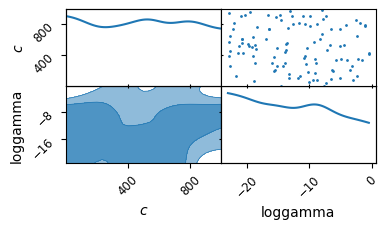

In [170]:
theta_samples.plot_2d(['c', 'loggamma'])